# COVID-19 en Colombia

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from sodapy import Socrata
import matplotlib.pyplot as plt

from pandas.plotting import lag_plot
from pandas.plotting import autocorrelation_plot

pd.options.display.max_columns = 50

## Descarga de Información
La descarga de la información se descarga usando la librería Socrata, la misma permite descargar la información más recuente. No obstante, si esta falla se lee una copia local de la información.

In [2]:
try:
    socrata_domain = "www.datos.gov.co"
    socrata_dataset_identifier = "gt2j-8ykr"

    client = Socrata(socrata_domain, None)
    results = client.get(socrata_dataset_identifier,limit=1000000000)
    
    df = pd.DataFrame.from_dict(results)
    df.to_csv('./spreadsheets/data_covid.csv', index=False)
    
    
    socrata_dataset_identifier = "8835-5baf"
    results = client.get(socrata_dataset_identifier,limit=1000000000)
    
    df_pruebas = pd.DataFrame.from_dict(results)
    df_pruebas.to_csv('./spreadsheets/pruebas_covid.csv', index=False)
    
except:
    df = pd.read_csv('./spreadsheets/data_covid.csv')
    df_pruebas = pd.read_csv('./spreadsheets/pruebas_covid.csv')
    
poblacion_ciudades = pd.read_csv('./spreadsheets/top20ciudades.csv')

### Estandarización de las columnas

Se cambian los valores nulos por el correspondiente valor en **numpy**.

In [3]:
df.fillna(value=np.NaN, inplace=True)

Se castean las columnas que contienen fechas.

In [4]:
date_columns = ['fecha_de_muerte',
                'fecha_recuperado', 
                'fecha_reporte_web',
                'fecha_diagnostico',
                'fecha_de_notificaci_n']

for col in date_columns:
    df[col] = pd.to_datetime(df[col])

Se castean variables que corresponden estrictamente a enteros.

In [5]:
df['edad'] = df['edad'].apply(lambda x: int(x))

Se eliminan diferencias en columnas que contoenen cadenas de caracteres con el fin de eliminar cualquier diferencia dado el uso de capitalización, mayúsculas y minúsculas.

In [6]:
cat_cols = ['sexo', 'tipo', 'estado', 'atenci_n', 'pertenencia_etnica', 'tipo_recuperaci_n']

for col in cat_cols:
    df[col] = df[col].apply(lambda x: str(x).strip().capitalize() if str(x) != 'N/A' else str(x).strip())

Se corrige el primer valor reportado de pruebas realizadas en el mes de Febrero y se le asigna el último día del mismo mes.

In [7]:
df_pruebas.replace("Acumulado Feb", value="2020-02-29T00:00:00.000", inplace = True)
df_pruebas['fecha'] = pd.to_datetime(df_pruebas['fecha'])
df_pruebas['acumuladas']= df_pruebas['acumuladas'].astype('int')
df_pruebas['acumuladas'] = df_pruebas['acumuladas'].diff()

df_pruebas.fillna(0, inplace=True)

## Exploración

In [8]:
df.head(2)

,id_de_caso,fecha_de_notificaci_n,c_digo_divipola,ciudad_de_ubicaci_n,departamento,atenci_n,edad,sexo,tipo,estado,pa_s_de_procedencia,fis,fecha_diagnostico,fecha_recuperado,fecha_reporte_web,tipo_recuperaci_n,codigo_departamento,codigo_pais,pertenencia_etnica,nombre_grupo_etnico,fecha_de_muerte
0,1,2020-03-02,11001,Bogotá D.C.,Bogotá D.C.,Recuperado,19,F,Importado,Leve,ITALIA,2020-02-27T00:00:00.000,2020-03-06,2020-03-13,2020-03-06,Pcr,11,380,Otro,NaN,NaT
1,2,2020-03-06,76111,Guadalajara de Buga,Valle del Cauca,Recuperado,34,M,Importado,Leve,ESPAÑA,2020-03-04T00:00:00.000,2020-03-09,2020-03-19,2020-03-09,Pcr,76,724,Otro,NaN,NaT


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 641574 entries, 0 to 641573
Data columns (total 21 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   id_de_caso             641574 non-null  object        
 1   fecha_de_notificaci_n  641574 non-null  datetime64[ns]
 2   c_digo_divipola        641574 non-null  object        
 3   ciudad_de_ubicaci_n    641574 non-null  object        
 4   departamento           641574 non-null  object        
 5   atenci_n               641574 non-null  object        
 6   edad                   641574 non-null  int64         
 7   sexo                   641574 non-null  object        
 8   tipo                   641574 non-null  object        
 9   estado                 641574 non-null  object        
 10  pa_s_de_procedencia    961 non-null     object        
 11  fis                    641574 non-null  object        
 12  fecha_diagnostico      637598 non-null  date

Se encuentra que la única columna que data de fechas con valores no nulos corresponde a`fecha_reporte_web` y se decide ordenar los datos de acuerdo a esta variable. La columna `fis` a pesar de corresponder a una variable con fechas contiene inconsistencias, por lo tanto no se tendrá en cuenta.

In [10]:
df = df.sort_values(by='fecha_reporte_web')

In [11]:
df.describe(include='all')

,id_de_caso,fecha_de_notificaci_n,c_digo_divipola,ciudad_de_ubicaci_n,departamento,atenci_n,edad,sexo,tipo,estado,pa_s_de_procedencia,fis,fecha_diagnostico,fecha_recuperado,fecha_reporte_web,tipo_recuperaci_n,codigo_departamento,codigo_pais,pertenencia_etnica,nombre_grupo_etnico,fecha_de_muerte
count,641574,641574,641574,641574,641574,641574,641574.000000,641574,641574,641574,961,641574,637598,489156,641574,641574,641574,962,641574,8139,21923
unique,641574,183,1028,954,37,6,NaN,2,3,6,48,628,179,173,179,3,33,43,5,88,167
top,630263,2020-07-27 00:00:00,11001,Bogotá D.C.,Bogotá D.C.,Recuperado,NaN,M,En estudio,Leve,ESPAÑA,Asintomático,2020-08-11 00:00:00,2020-08-23 00:00:00,2020-08-19 00:00:00,Tiempo,11,724,Nan,ZENÚ,2020-07-30 00:00:00
freq,1,12108,219584,219584,219584,489151,NaN,329351,609301,517281,265,77805,17455,14150,13056,397314,219584,265,360093,1839,371
first,NaN,2020-03-02 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2020-03-06 00:00:00,2020-03-13 00:00:00,2020-03-06 00:00:00,NaN,NaN,NaN,NaN,NaN,2020-03-16 00:00:00
last,NaN,2020-09-03 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2020-09-03 00:00:00,2020-09-03 00:00:00,2020-09-03 00:00:00,NaN,NaN,NaN,NaN,NaN,2020-09-03 00:00:00
mean,NaN,NaN,NaN,NaN,NaN,NaN,39.660571,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
std,NaN,NaN,NaN,NaN,NaN,NaN,18.143241,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25%,NaN,NaN,NaN,NaN,NaN,NaN,27.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Se chequean los valores nulos en el dataset, respecto al total de récords en el mismo, a fin de expresar estos como porcentaje.

In [12]:
df.isna().sum()[df.isna().sum()>0].to_frame('Nulls') / len(df)*100

,Nulls
pa_s_de_procedencia,99.850212
fecha_diagnostico,0.619726
fecha_recuperado,23.756885
codigo_pais,99.850056
nombre_grupo_etnico,98.731401
fecha_de_muerte,96.582935


La columna `pa_s_de_procedencia` y `codigo_pais` cuentan con un significativo porcentaje de nulos ya que los casos que se dan entre personas que no contrajeron el virus en el exterior no cuentan con un valor. Por otro lado, la columna `fecha_de_muerte` cuenta con un alto porcentaje de nulos dada la baja mortalidad del virus. Finalmente, las columnas `pertenencia_etnica` y `nombre_grupo_etnica` cuentan con valores nulos dado el desconocimiento de dicha clasificación por parte de los pacientes.

Antes de continuar con el análisis se decidió prescindir de aquellas columnas que no agregan información.

In [13]:
to_drop = ['id_de_caso', 'fis', 'c_digo_divipola', 'codigo_departamento','codigo_pais']

df.drop(labels=to_drop, axis=1, inplace=True)

In [14]:
df.head()

,fecha_de_notificaci_n,ciudad_de_ubicaci_n,departamento,atenci_n,edad,sexo,tipo,estado,pa_s_de_procedencia,fecha_diagnostico,fecha_recuperado,fecha_reporte_web,tipo_recuperaci_n,pertenencia_etnica,nombre_grupo_etnico,fecha_de_muerte
0,2020-03-02,Bogotá D.C.,Bogotá D.C.,Recuperado,19,F,Importado,Leve,ITALIA,2020-03-06,2020-03-13,2020-03-06,Pcr,Otro,NaN,NaT
1,2020-03-06,Guadalajara de Buga,Valle del Cauca,Recuperado,34,M,Importado,Leve,ESPAÑA,2020-03-09,2020-03-19,2020-03-09,Pcr,Otro,NaN,NaT
2,2020-03-07,Medellín,Antioquia,Recuperado,50,F,Importado,Leve,ESPAÑA,2020-03-09,2020-03-15,2020-03-09,Pcr,Otro,NaN,NaT
3,2020-03-09,Medellín,Antioquia,Recuperado,55,M,Relacionado,Leve,NaN,2020-03-11,2020-03-26,2020-03-11,Pcr,Otro,NaN,NaT
4,2020-03-09,Medellín,Antioquia,Recuperado,25,M,Relacionado,Leve,NaN,2020-03-11,2020-03-23,2020-03-11,Pcr,Otro,NaN,NaT


### Análisis Gráfico

Se analizan las variables categóricas y numéricas las cuales permitieron entender la distribución del virus en distintos niveles:
- Nivel País
- Nivel Ciudad (Top 5 ciudades con más casos)

#### Nivel País

El análisis comienza por un chequeo de la evolución del virus día a día.

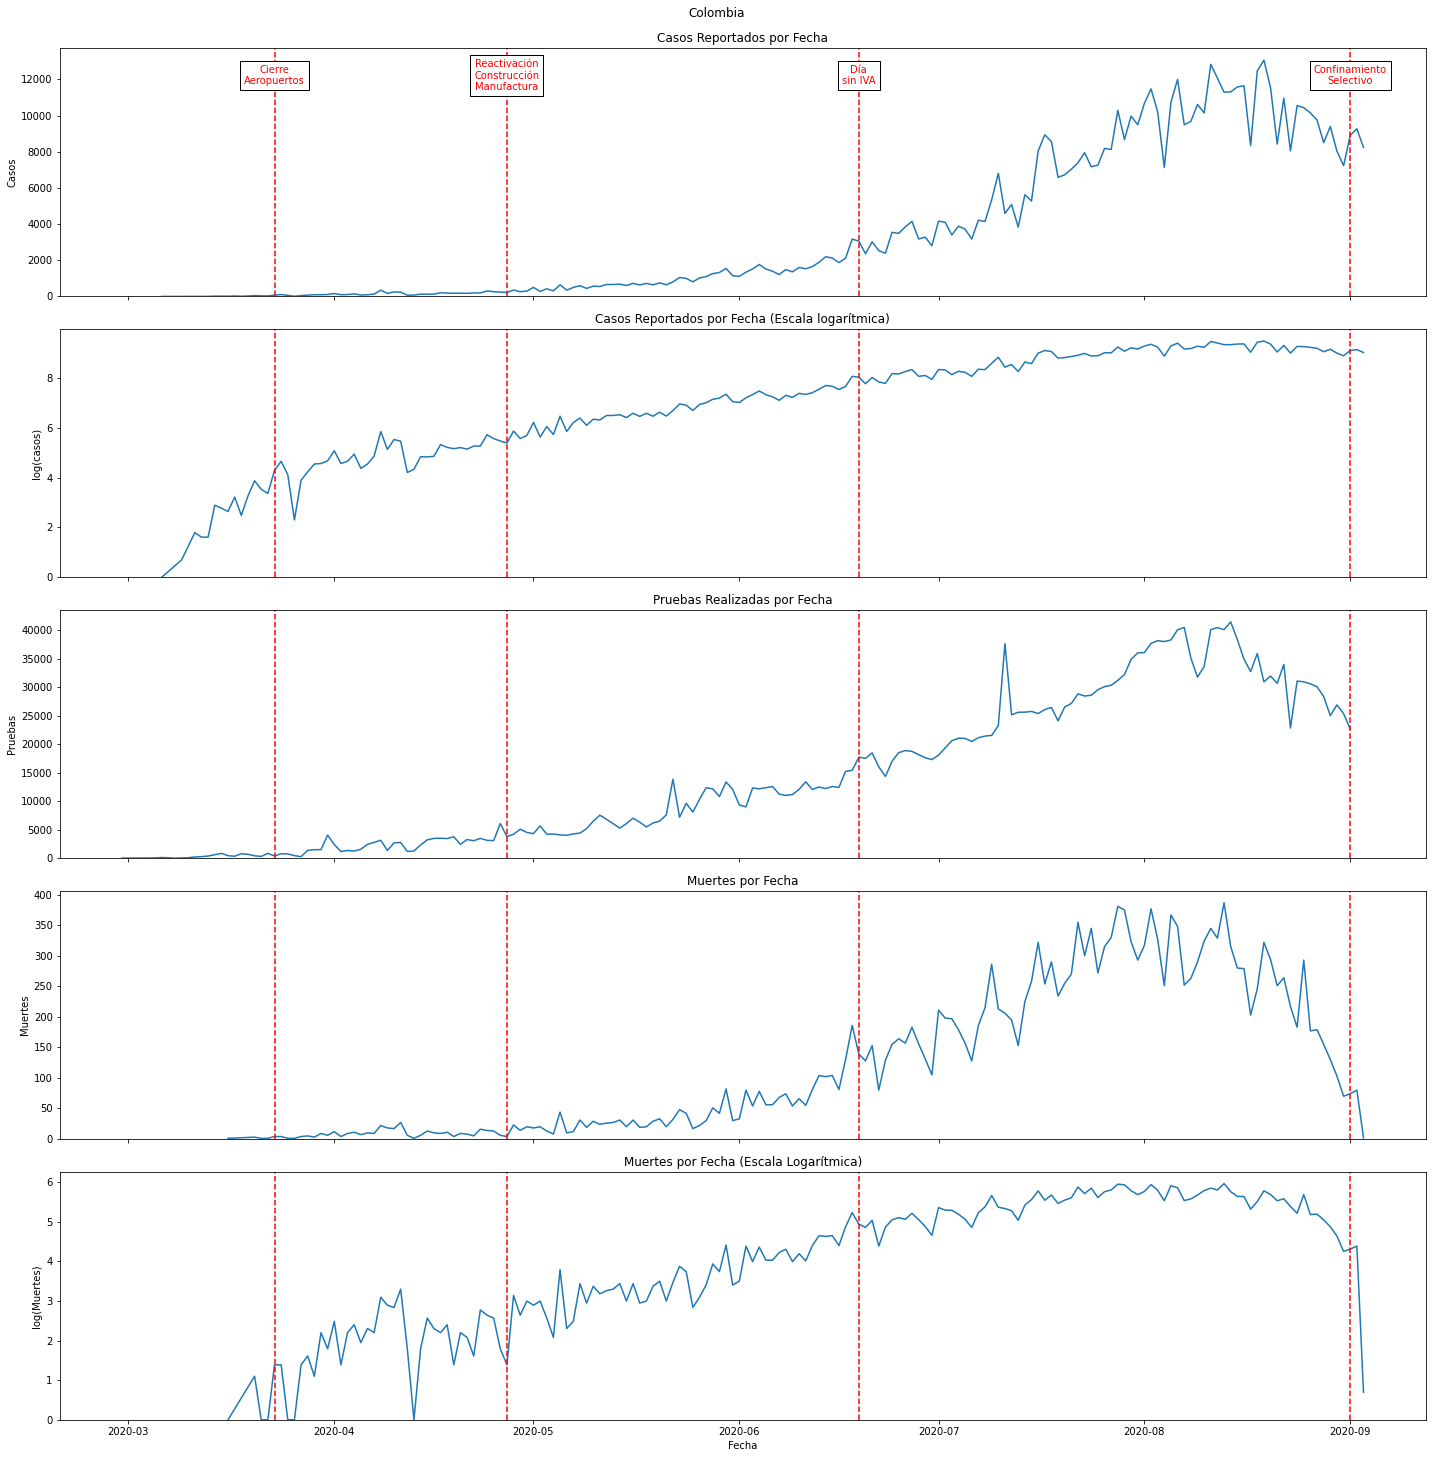

In [15]:
#Se agrupa el total de infecciones por fecha
total_infecciones = df.groupby(by=['fecha_reporte_web'],as_index=False).count()[['fecha_reporte_web','edad']]
total_infecciones.rename(columns={'edad':'casos'}, inplace=True)

#Se agrupa el total de pruebas realizadas por fecha
total_muestras = df_pruebas.groupby(by='fecha', as_index=False).sum()

#Se agrupa el total de muertes ocurridas por fecha
total_muertes = df[df['atenci_n']=='Fallecido'].groupby(by=['fecha_reporte_web'], as_index=False).count()[['fecha_reporte_web','edad']]
total_muertes.rename(columns={'edad':'casos'}, inplace=True)


fig,axes = plt.subplots(5, 1, figsize=(20,20), sharex=True)

axes[0].plot(total_infecciones['fecha_reporte_web'],total_infecciones['casos'])
axes[0].set_title('Casos Reportados por Fecha')
axes[0].set_ylabel('Casos')

axes[1].plot(total_infecciones['fecha_reporte_web'],np.log(total_infecciones['casos']))
axes[1].set_title('Casos Reportados por Fecha (Escala logarítmica)')
axes[1].set_ylabel('log(casos)')


axes[2].plot(total_muestras['fecha'], total_muestras['acumuladas'])
axes[2].set_title('Pruebas Realizadas por Fecha')
axes[2].set_ylabel('Pruebas')

axes[3].plot(total_muertes['fecha_reporte_web'], total_muertes['casos'])
axes[3].set_title('Muertes por Fecha')
axes[3].set_ylabel('Muertes')

axes[4].plot(total_muertes['fecha_reporte_web'], np.log(total_muertes['casos']))
axes[4].set_title('Muertes por Fecha (Escala Logarítmica)')
axes[4].set_ylabel('log(Muertes)')
axes[4].set_xlabel('Fecha')



label_list = [
    (pd.to_datetime("2020-03-23"), 'Cierre\nAeropuertos', 'r'),
    (pd.to_datetime("2020-04-27"), 'Reactivación\nConstrucción\nManufactura', 'r'),
    (pd.to_datetime("2020-06-19"), "Día\nsin IVA", 'r'),
    (pd.to_datetime("2020-09-01"), "Confinamiento\nSelectivo", 'r')
]
ax = plt.gca()
for i, ax_ in enumerate(axes):
    for date_point, label, clr in label_list:
        ax_.axvline(x=date_point, color=clr, ls='--')
        ax_.set_ylim(0,)
        if i ==0:
            ax_.text(date_point, ax_.get_ylim()[1]-1500, label, horizontalalignment='center',
                 verticalalignment='center', color=clr, bbox=dict(facecolor='white', alpha=1))

plt.suptitle('Colombia',x=0.5,y=1.01)
plt.tight_layout()
plt.show()

Se apreció una caída en el número de contagios dado el cierre de los aeropuertos (en la escala logarítmica) a pesar de un aumento consistente en el número de pruebas realizado. Ahora bien, las muertes en el mismo período muestran un comportamiento similar al número de contagios.

A continuación se describen gráficamente variables categóricas a fin de proporcionar una idea de la distribución del virus respecto a distintas subcategorías como sexo, tipo de recuperación, etc.

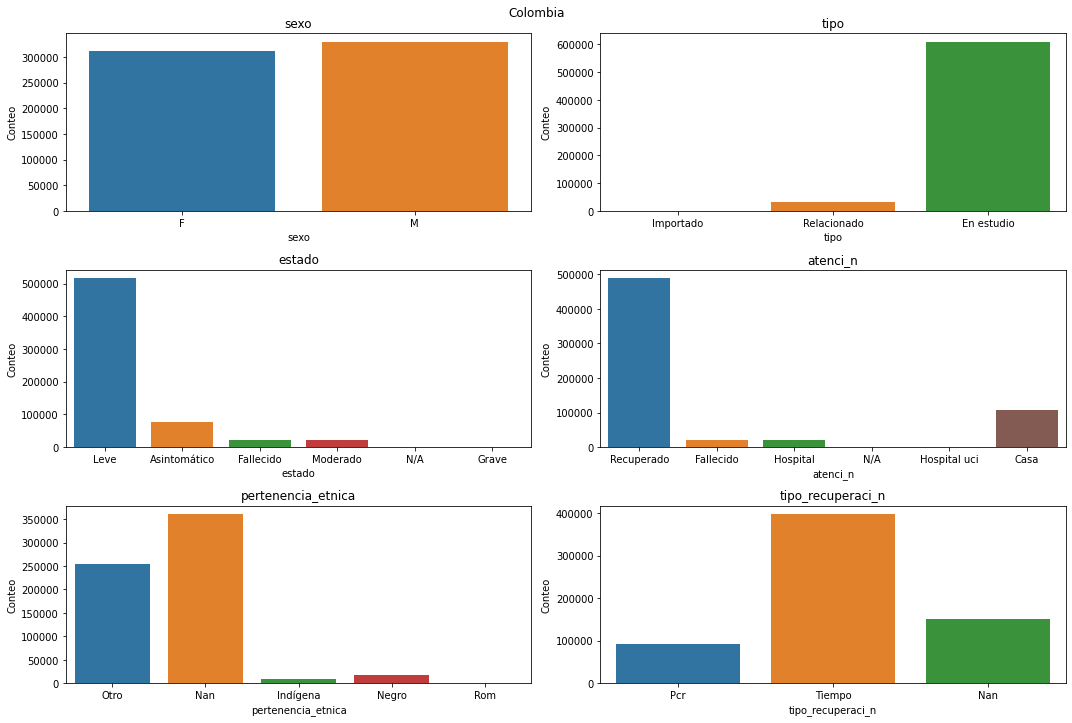

In [16]:
fig, axes = plt.subplots(3,2, figsize=(20,10))

axes = axes.ravel()

for i,col in enumerate(cat_cols):
    sns.countplot(df[col], ax=axes[i])
    axes[i].set_ylabel('Conteo')
    axes[i].set_title(str(col))

plt.suptitle('Colombia',x=0.5,y=1)
plt.tight_layout()
plt.show()

Finalmente, se chequeó la distribución de edades de los infectados en Colombia.

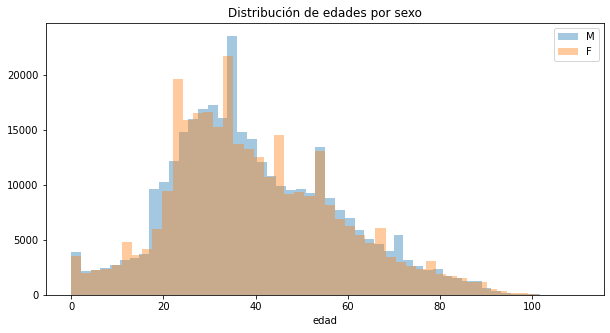

In [17]:
plt.figure(figsize=(10,5))
sns.distplot(df[df['sexo']=='M']['edad'], label = 'M', kde=False)
sns.distplot(df[df['sexo']=='F']['edad'], label = 'F', kde=False)

plt.title('Distribución de edades por sexo')
plt.legend()
plt.show()

No se encuentró mayor diferencia respecto a la distribución de acuerdo al sexo.

#### Nivel Ciudad en el Top 5

Antes de continuar con el análisis se distinguieron aquellas ciudades que cuentan con el mayor número de contagios.

In [18]:
ciudades_top = df.groupby(by=['ciudad_de_ubicaci_n'], as_index=False).count()[['ciudad_de_ubicaci_n', 'edad']]
ciudades_top.rename(columns={'edad':'casos'},inplace=True)

Se guardan dichas ciudades en una variable para su posterior uso.

In [19]:
top_5 = list(ciudades_top.sort_values(by=['casos'], ascending=False)['ciudad_de_ubicaci_n'][:5])
print(top_5)

['Bogotá D.C.', 'Medellín', 'Cali', 'Barranquilla', 'Cartagena de Indias']


Se analizó gráficamente el total de casos en las ciudades mencionadas.

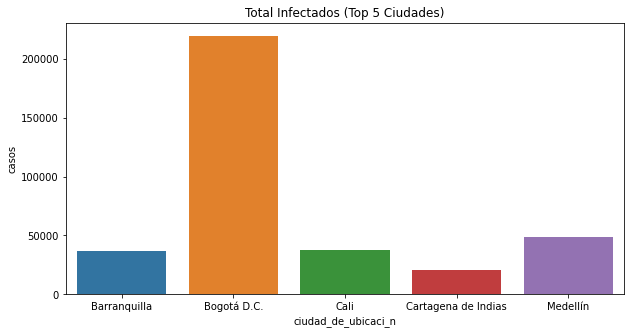

In [20]:
plt.figure(figsize=(10,5))
sns.barplot(x='ciudad_de_ubicaci_n', y='casos', data=ciudades_top[ciudades_top['ciudad_de_ubicaci_n'].isin(top_5) ])
plt.title('Total Infectados (Top 5 Ciudades)')
plt.show()

Se encontró que Bogotá D.C cuenta con el mayor número de infectados.

Se realizó la extracción de las variables de interés para el modelado que se llevará a cabo posteriormente, así se distinguieron:
- Población de la Ciudad (P)
- Total de Muertes (M)
- Población Susceptible al contagio (S)
- Total de Infectados (I)
- Total de Recuperados (R)

In [21]:
df_ciudades = {}
df_SIR = {}
cols_interes = ['fecha_de_notificaci_n', 'ciudad_de_ubicaci_n', 'atenci_n', 'edad', 'sexo', 'fecha_de_muerte', 'estado', 'fecha_recuperado']

In [22]:
for ciudad in top_5:
    df_ciudades[ciudad] = df[df['ciudad_de_ubicaci_n'] == ciudad][cols_interes].reset_index(drop=True)
    df_ciudades[ciudad].rename(columns={'ciudad_de_ubicaci_n':'Ciudad', 'fecha_de_notificaci_n':'fecha'},inplace=True)
    
    df_SIR[ciudad] = df_ciudades[ciudad].groupby('fecha', as_index=False).agg({'edad':'count'})
    df_SIR[ciudad]['P'] = list(poblacion_ciudades[poblacion_ciudades['Ciudad']==ciudad]['Población'])[0]
    df_SIR[ciudad].rename(columns={'edad':'I'},inplace=True)
    
    recuperados = df_ciudades[ciudad].groupby(['fecha_recuperado','atenci_n'], as_index=False).count()[['fecha_recuperado','atenci_n','Ciudad']]
    recuperados.rename(columns={'Ciudad':'R', 'fecha_recuperado':'fecha'},inplace=True)
    recuperados = recuperados[recuperados['atenci_n']=='Recuperado']
    
    muertes = df_ciudades[ciudad].groupby(['fecha_de_muerte','estado'], as_index=False).count()[['fecha_de_muerte','estado','Ciudad']]
    muertes.rename(columns={'Ciudad':'M', 'fecha_de_muerte':'fecha'},inplace=True)
    muertes = muertes[muertes['estado']=='Fallecido']
    
    df_SIR[ciudad] = pd.merge(df_SIR[ciudad], recuperados, on=['fecha'], how='outer').drop('atenci_n', axis=1)
    df_SIR[ciudad] = pd.merge(df_SIR[ciudad], muertes, on=['fecha'], how='outer').drop('estado', axis=1)
    
    df_SIR[ciudad]['dI_dt'] = df_SIR[ciudad]['I'].diff()
    df_SIR[ciudad]['dR_dt'] = df_SIR[ciudad]['R'].diff()
    
    df_SIR[ciudad].sort_values(by='fecha',inplace=True)
    df_SIR[ciudad].fillna(0)
     
    
    #df_SIR[ciudad]['S'] = df_SIR[ciudad]['P']  - df_SIR[ciudad]['I'] - df_SIR[ciudad]['R']

Se llevó a cabo un análisis gráfico de la distribución de edades (diferenciado por sexo) y ciudad.

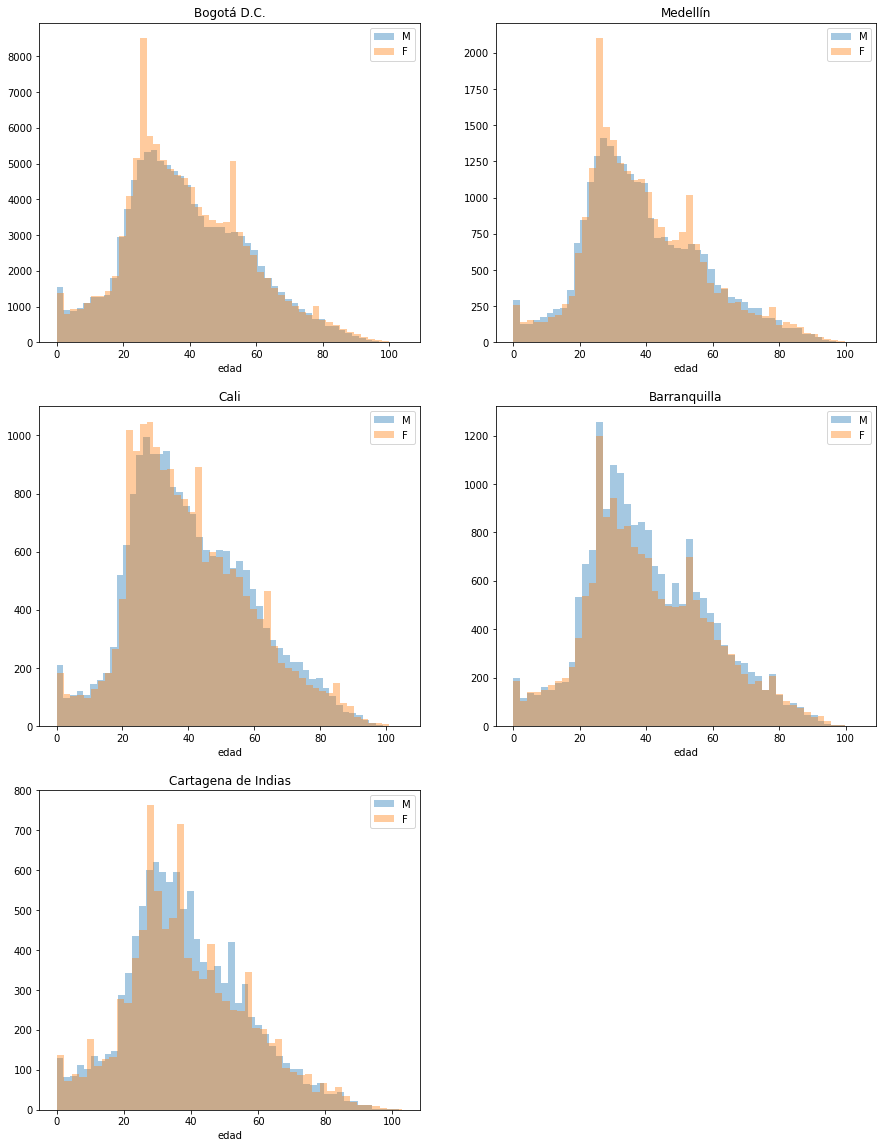

In [23]:
fig, axes = plt.subplots(3,2, figsize=(15,20))

for i, ciudad in enumerate(top_5):
    ax = axes.flatten()[i]
    ax.set_title(ciudad)
    sns.distplot(df_ciudades[ciudad][df_ciudades[ciudad]['sexo']=='M']['edad'], label = 'M', kde=False, ax=ax)
    sns.distplot(df_ciudades[ciudad][df_ciudades[ciudad]['sexo']=='F']['edad'], label = 'F', kde=False, ax=ax)
    ax.legend()
    
fig.delaxes(axes[2,1])

Se evidenció un comportamiento similar al del país, en el que no se encontró mayor diferencia entre las edades de los infectados.

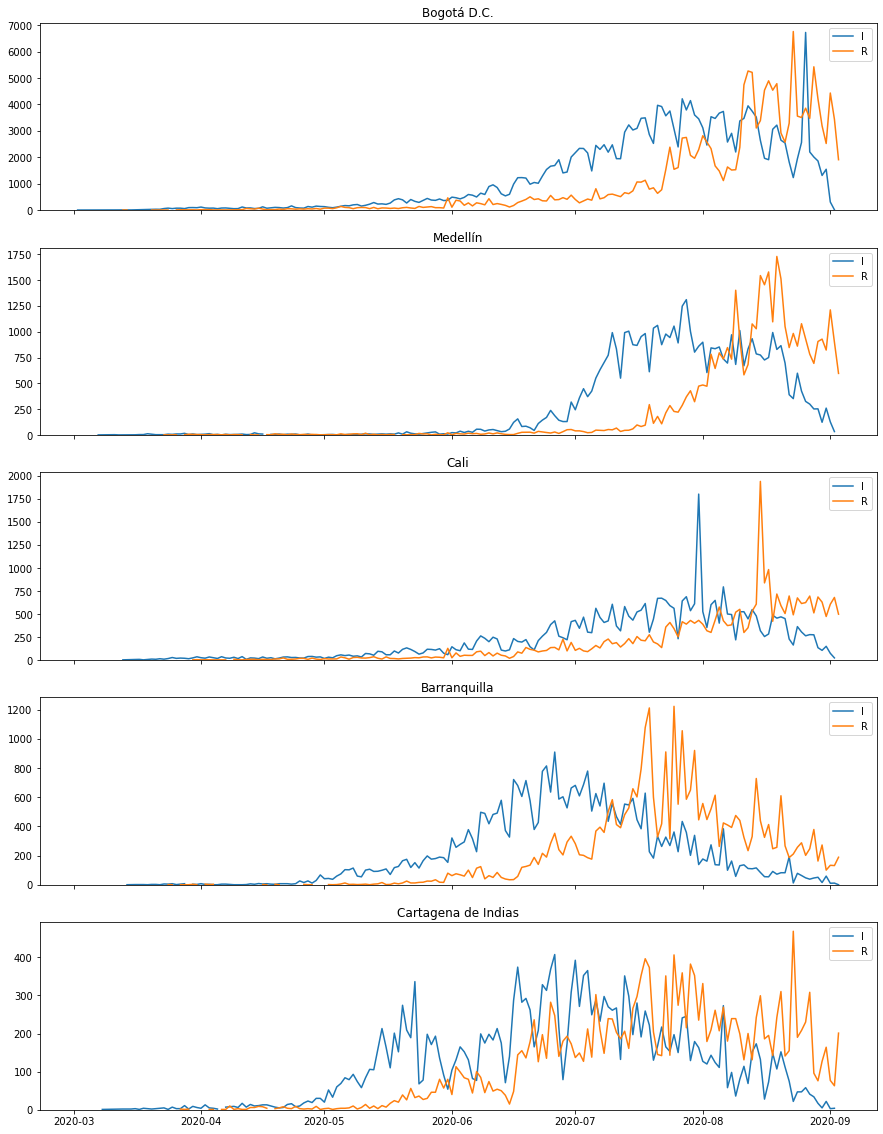

In [24]:
fig, axes = plt.subplots(5,1, figsize=(15,20),sharex=True)

for i, ciudad in enumerate(top_5):
    ax = axes.flatten()[i]
    ax.set_title(ciudad)
    
    ax.plot(df_SIR[ciudad]['fecha'], df_SIR[ciudad]['I'], label='I')
    ax.plot(df_SIR[ciudad]['fecha'], df_SIR[ciudad]['R'], label='R')
    
    ax.set_ylim(0,)
    
    ax.legend()

Se estimó la variación en el tiempo de las anteriores variables, las cuales se aprecian a continuación.

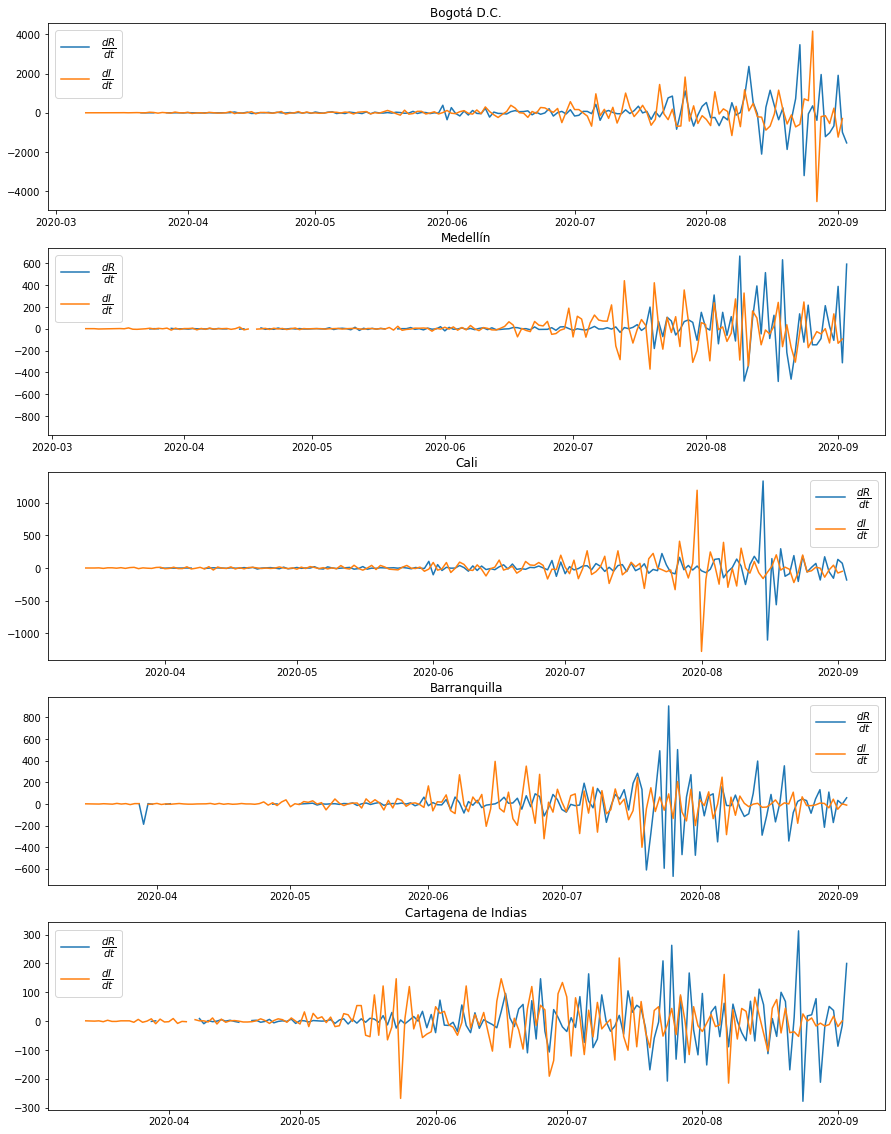

In [25]:
fig, axes = plt.subplots(5,1, figsize=(15,20))

for i, ciudad in enumerate(top_5):
    ax = axes.flatten()[i]
    ax.set_title(ciudad)
    
    ax.plot(df_SIR[ciudad]['fecha'], df_SIR[ciudad]['dR_dt'], label=r'$\frac{dR}{dt}$')
    ax.plot(df_SIR[ciudad]['fecha'], df_SIR[ciudad]['dI_dt'], label=r'$\frac{dI}{dt}$')
    
    ax.legend(fontsize='x-large')

Se apreciaron fluctuaciones en ambas tasas, problablemente ligadas a las restricciones impuestas por el estado.

Ahora bien, a nivel de ciudad en lo corrido de la pandemia se encuentran las siguientes métricas.

In [26]:
df_agrupado = df[df['ciudad_de_ubicaci_n'].isin(top_5)].groupby(by=['ciudad_de_ubicaci_n', 'atenci_n'], as_index=False).count()[['ciudad_de_ubicaci_n', 'atenci_n', 'edad']]
df_agrupado.sort_values(by='ciudad_de_ubicaci_n', ascending = True, inplace=True)
df_agrupado.rename(columns={'edad':'casos'},inplace=True)
df_agrupado.head()

,ciudad_de_ubicaci_n,atenci_n,casos
0,Barranquilla,Casa,1030
1,Barranquilla,Fallecido,1624
2,Barranquilla,Hospital,380
3,Barranquilla,Hospital uci,34
4,Barranquilla,N/A,103


In [27]:
total_ciudad = df_agrupado.groupby(by=['ciudad_de_ubicaci_n'], as_index=False).sum()
total_ciudad.rename(columns={'casos':'infectados'}, inplace=True)
total_ciudad.head()

,ciudad_de_ubicaci_n,infectados
0,Barranquilla,36448
1,Bogotá D.C.,219584
2,Cali,38070
3,Cartagena de Indias,20697
4,Medellín,48968


In [28]:
total_ciudad['recuperados'] = df_agrupado[df_agrupado['atenci_n']=='Recuperado']['casos'].to_list()
total_ciudad.head()

,ciudad_de_ubicaci_n,infectados,recuperados
0,Barranquilla,36448,33277
1,Bogotá D.C.,219584,160976
2,Cali,38070,30644
3,Cartagena de Indias,20697,18805
4,Medellín,48968,38018


In [29]:
total_ciudad['muertes'] = df_agrupado[df_agrupado['atenci_n']=='Fallecido']['casos'].to_list()
total_ciudad.head()

,ciudad_de_ubicaci_n,infectados,recuperados,muertes
0,Barranquilla,36448,33277,1624
1,Bogotá D.C.,219584,160976,5652
2,Cali,38070,30644,1320
3,Cartagena de Indias,20697,18805,528
4,Medellín,48968,38018,1000


# Feature Engineering

## Lag Plot

La gráfica "Lag" o "Shift" permite apreciar la relación de un evento `y(t+n)` respecto al valor real `y(t)`.

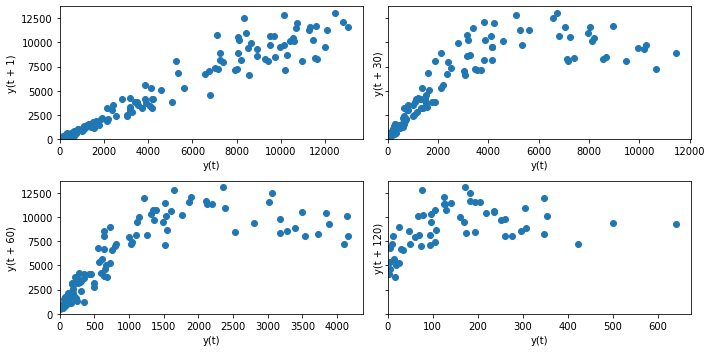

In [30]:
fig, axes = plt.subplots(2, 2,figsize=(10,5), sharex=False, sharey=True)
lags = [1,30,60,120]

for ax,i in enumerate(lags):
    ax = axes.flatten()[ax]
    ax = lag_plot(total_infecciones['casos'], lag=i, ax=ax)
    ax.set_xlim(0,)
    ax.set_ylim(0,)

plt.tight_layout()
plt.show()

La gráfica de correlación permite estimar el número de valores `n` que se pueden tomar sin que esta transformación deteriore la relación de los datos.

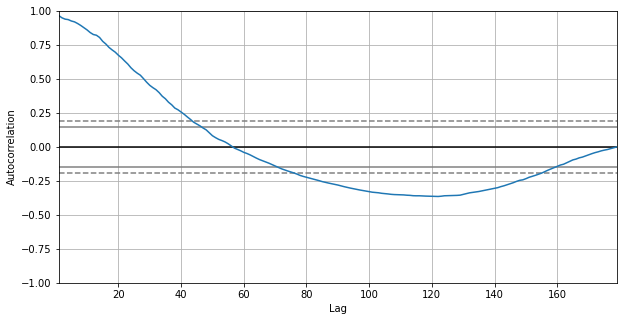

In [31]:
plt.figure(figsize=(10,5))
autocorrelation_plot(total_infecciones['casos'])
plt.show()

Se apreció un alto coeficiente de autocorrelación para transformaciones que incluyan menos de 20 valores y un mínimo al rededor de los 12 días, es decir, 4 meses.

### Windowing

In [32]:
total_infecciones['roll_mean'] = total_infecciones['casos'].rolling(window=10).mean()
total_infecciones['roll_max'] = total_infecciones['casos'].rolling(window=2).max()
total_infecciones.head(3)

,fecha_reporte_web,casos,roll_mean,roll_max
0,2020-03-06,1,NaN,NaN
1,2020-03-09,2,NaN,2.0
2,2020-03-11,6,NaN,6.0


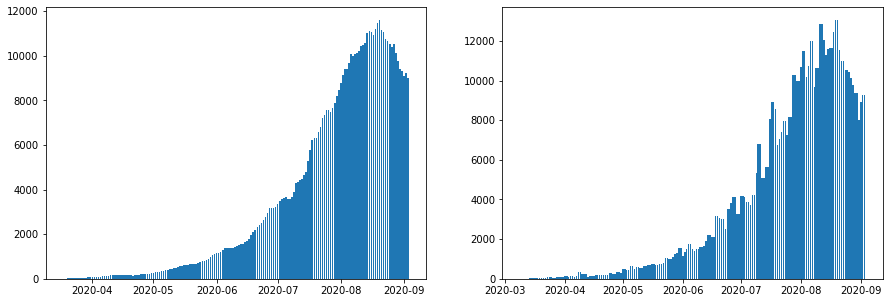

In [33]:
fig, axes = plt.subplots(1,2, figsize=(15,5))
axes[0].bar(total_infecciones['fecha_reporte_web'], total_infecciones['roll_mean'])
axes[1].bar(total_infecciones['fecha_reporte_web'], total_infecciones['roll_max'])
plt.show()

### Expanding

In [34]:
total_infecciones['exp_mean'] = total_infecciones['casos'].expanding().mean()
total_infecciones['exp_max'] = total_infecciones['casos'].expanding().max()
total_infecciones.head(3)

,fecha_reporte_web,casos,roll_mean,roll_max,exp_mean,exp_max
0,2020-03-06,1,NaN,NaN,1.0,1.0
1,2020-03-09,2,NaN,2.0,1.5,2.0
2,2020-03-11,6,NaN,6.0,3.0,6.0


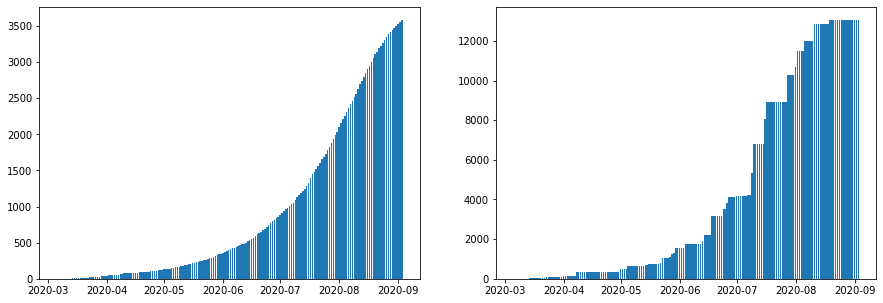

In [35]:
fig, axes = plt.subplots(1,2, figsize=(15,5))
axes[0].bar(total_infecciones['fecha_reporte_web'], total_infecciones['exp_mean'])
axes[1].bar(total_infecciones['fecha_reporte_web'], total_infecciones['exp_max'])
plt.show()